In [1]:
import numpy as np
import scipy.signal as signal

from pytest import approx

In [2]:
%load_ext Cython

In [3]:
def python_v(cwfs, adc_to_pes,
             n_MAU = 100, thr_MAU = 3):
    adc_to_pes  = adc_to_pes.reshape(adc_to_pes.size, 1)
    MAU         = np.full(n_MAU, 1 / n_MAU)
    mau         = signal.lfilter(MAU, 1, cwfs, axis=1)

    # ccwfs stands for calibrated corrected waveforms
    ccwfs       = cwfs / adc_to_pes
    ccwfs_mau   = np.where(cwfs >= mau + thr_MAU, ccwfs, 0)

    cwf_sum     = np.sum(ccwfs    , axis=0)
    cwf_sum_mau = np.sum(ccwfs_mau, axis=0)
    return ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau

In [4]:
%%cython

cimport numpy as np
import  numpy as np
from scipy import signal


cpdef cython_v(double [:, :] CWF, double [:] adc_to_pes,
               int n_MAU = 100  , double thr_MAU = 3):
    cdef int j, k
    cdef int NPMT = CWF.shape[0]
    cdef int NWF  = CWF.shape[1]
    cdef list PMT = list(range(NPMT))

    cdef double [:] MAU = np.array(np.ones(n_MAU),
                                   dtype = np.double) * (1 / n_MAU)

    # CWF if above MAU threshold
    cdef double [:, :] pmt_thr  = np.zeros((NPMT, NWF), dtype=np.double)
    cdef double [:, :] pmt_thr_mau  = np.zeros((NPMT, NWF), dtype=np.double)
    cdef double [:]    MAU_pmt  = np.zeros(      NWF, dtype=np.double)

    for j in PMT:
        # MAU for each of the PMTs, following the waveform
        MAU_pmt = signal.lfilter(MAU, 1, CWF[j,:])

        for k in range(NWF):
            pmt_thr[j,k] = CWF[j,k] * 1 / adc_to_pes[j]
            if CWF[j,k] >= MAU_pmt[k] + thr_MAU: # >= not >: found testing!
                pmt_thr_mau[j,k] = CWF[j,k] * 1 / adc_to_pes[j]

    return np.asarray(pmt_thr), np.asarray(pmt_thr_mau)

In [5]:
NPMT, NWF  =   5, 1000
n_MAU, thr = 100, 3.0

random_wfs = lambda: np.random.rand(NPMT, NWF) * 10
adc_to_pes = np.random.rand(NPMT)
active     = np.ones_like  (adc_to_pes, dtype=bool)

In [7]:
py_t = %timeit -n 100 -r 10 -o python_v(random_wfs(), adc_to_pes, n_MAU, thr)

755 µs ± 188 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [8]:
cy_t = %timeit -n 100 -r 10 -o cython_v(random_wfs(), adc_to_pes, n_MAU, thr)

1.17 ms ± 111 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [9]:
py_t.worst, cy_t.worst

(0.0013140518699947278, 0.001494588420027867)

In [12]:
for i in range(1000):
    wfs = random_wfs()
    py_result = python_v(wfs, adc_to_pes, n_MAU, thr)
    cy_result = cython_v(wfs, adc_to_pes, n_MAU, thr)
    
    assert py_result[0] == approx(cy_result[0])
    assert py_result[1] == approx(cy_result[1])

In [11]:
def python_v(rwfs, adc_to_pes, thr, n_MAU=100):
    unifm = np.full(n_MAU, 1/n_MAU)
    blswf = rwfs.T - np.mean(rwfs ,           axis=1)
    mau   = signal.lfilter  (unifm, 1, blswf, axis=0)
    calwf = np.where(blswf > mau + thr * adc_to_pes, blswf / adc_to_pes, 0)
    return calwf.T

In [12]:
%%cython

cimport numpy as np
import  numpy as np
from scipy import signal



cpdef cython_v(np.ndarray[np.int16_t, ndim=2] SIPM,
                   double [:] adc_to_pes, thr,
                   int n_MAU=100):
    cdef int j, k
    cdef double [:, :] SiWF = SIPM.astype(np.double)
    cdef int NSiPM = SiWF.shape[0]
    cdef int NSiWF = SiWF.shape[1]
    cdef double [:] MAU = np.array(np.ones(n_MAU),
                                   dtype = np.double) * (1 / n_MAU)

    cdef double [:, :] siwf = np.zeros((NSiPM, NSiWF), dtype=np.double)
    cdef double [:]    MAU_ = np.zeros(        NSiWF , dtype=np.double)
    cdef double [:]    thrs = np.full ( NSiPM, thr)
    cdef double pmean

    # loop over all SiPMs. Skip any SiPM with adc_to_pes constant = 0
    # since this means SiPM is dead
    for j in range(NSiPM):
        if adc_to_pes[j] == 0:
            #print('adc_to_pes[{}] = 0, setting sipm waveform to zero'.format(j))
            continue

        # compute and subtract the baseline
        pmean = 0
        for k in range(NSiWF):
            pmean += SiWF[j,k]
        pmean /= NSiWF

        for k in range(NSiWF):
            SiWF[j,k] = SiWF[j,k] - pmean

        # MAU for each of the SiPMs, following the ZS waveform
        MAU_ = signal.lfilter(MAU, 1, SiWF[j,:])

        # threshold using the MAU
        for k in range(NSiWF):
            if SiWF[j,k]  > MAU_[k] + thrs[j] * adc_to_pes[j]:
                siwf[j,k] = SiWF[j,k] / adc_to_pes[j]

    return np.asarray(siwf)

In [13]:
random_wfs = lambda: np.random.randint(0, 10, size=(NPMT, NWF)).astype(np.int16)

In [14]:
%timeit -n 1000 -r 10 python_v(random_wfs(), adc_to_pes, thr, n_MAU)

418 µs ± 91.5 µs per loop (mean ± std. dev. of 10 runs, 1000 loops each)


In [15]:
%timeit -n 1000 -r 10 cython_v(random_wfs(), adc_to_pes, thr, n_MAU)

913 µs ± 90.5 µs per loop (mean ± std. dev. of 10 runs, 1000 loops each)


In [16]:
wfs = random_wfs()
py_result = python_v(wfs, adc_to_pes, thr, n_MAU)
cy_result = cython_v(wfs, adc_to_pes, thr, n_MAU)
py_result == approx(cy_result)

True

In [18]:
import numpy as np
import scipy.signal as sg
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = 12, 8

In [41]:
x  = np.linspace(-5, 5, 1000)
y  = np.where(x < 0, 0, np.sin(x))
y  = np.sin(x)
y += np.random.normal(y, 0.1)

x_  = x[200:800]
y_  = y[200:800]
mau = np.full(10, 0.1)
fy  = sg.lfilter(mau, 1, y)

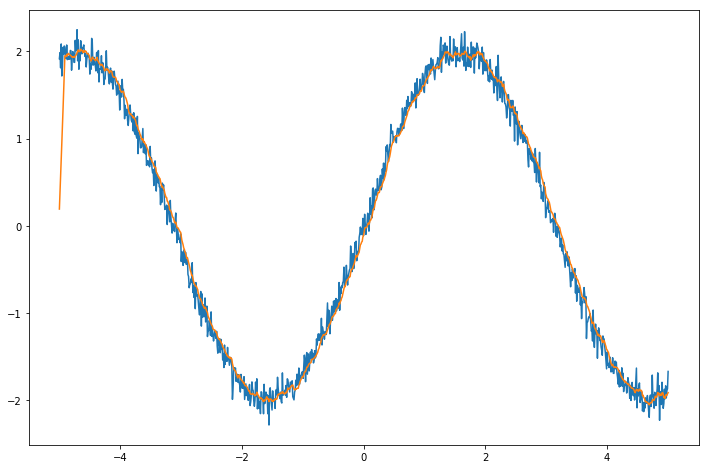

In [42]:
plt.plot(x, y)
plt.plot(x, fy)

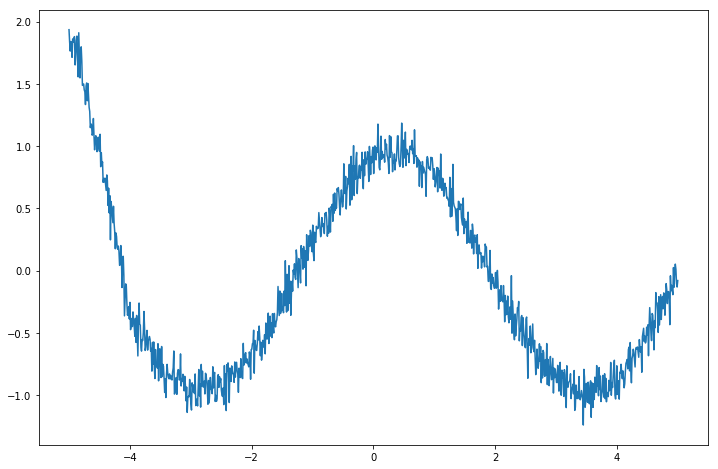

In [32]:
plt.plot(x, data - fdata)